## 🔮 Deep Learning in Practice


<img src="https://i.imgur.com/4RUm91Y.png">

<table>
  <tr> <th>torch</th> <th>torch.nn</th> <th>torch.nn.functional</th> <th>torch.optim</th> <th>torch.utils</th> </tr>
  <tr> 
  <td> Wraps all other modules and offers tensor functionality on GPU and automatic differentiation </td> 
  <td> Basic blocks of neural networks (i.e., layers, activations and loss functions) </td> 
  <td> Stateless functional version of (torch.nn) </td> 
  <td> Optimization algorithms and learning rate schedulers</td> 
  <td> reading data, batching, logging, etc. </td> </tr>
</table>


We're done with `torch` and `torch.utils` and `torch.optm`. Let's have a look at `torch.nn`.

`torch.nn` helps us accomplish the first two steps of the "deep learning framework":

1. Define the hypothesis function $f(x;θ)$ (i.e., the model architecture)

2. Define the loss function $J(y, f(x;θ))$

For (1), it makes the following assumption:

- We can model $f(x;θ)$ via a sequence of operations

  - Have seen in the last lab that it holds for feedforward neural networks (i.e., forward loop)

  - Holds generally for any deep learning model: but some operations may have multiple inputs 

**Abstraction:** Model each of such operations as a layer
  - From the lab, we already know that any "diagrammatic" layer (except input) in a feedforward neural network is an operation $f(Wa+b)$
  - Holds for other deep learning network as well

This is different from what you did in the lab in the sense that it allows the developer to arbitrarily mix and match the layers (corresponding to operations) together which enables more opportunities for research.

**Let's implement the layer corresponding to $Z = Wa+b$:**

In [2]:
import torch

class SimpleLinearLayer:
    def __init__(self, input_size, output_size):
        # Initialize weights
        self.weight = torch.randn(output_size, input_size)      # W
        self.bias = torch.randn(output_size)                    # b

    def forward(self, x):
        z = x @ self.weight.T + self.bias                       # [1,n]*[n,nl] → [1,nl]
        return z

# 1. Define the layer
simple_linear_layer = SimpleLinearLayer(10, 5)

# 2. Use the layer
simple_linear_layer.forward(torch.rand(1, 10))

tensor([[-0.9987,  0.6166,  0.2570,  2.2508,  1.3831]])

If we make multiple instances of this and call one after another we effectively realize a neural network, right? 

This is the scheme in which PyTorch implements operations (along with their parameters). In PyTorch, the layer we defined above is simply called `LinearLayer`. 

In [3]:
import torch
import torch.nn as nn

# 1. Define the layer
pytorch_linear_layer = nn.Linear(10, 5)

# 2. Use the layer
pytorch_linear_layer(torch.rand(1, 10))    # Notice: didn't have to call forward explictly

tensor([[ 0.3992,  0.5121, -0.1557,  0.7690, -0.0373]],
       grad_fn=<AddmmBackward0>)

The `torch.nn` also supports a large class of activation functions which are also treated like layers

In [6]:
# 1. Define the layer
relu_layer = nn.LeakyReLU(negative_slope=0.01)

# 2. Use the layer
relu_layer(torch.randn(1, 10))

tensor([[ 5.2085e-01,  5.0831e-01,  2.0265e-01, -1.1908e-03,  7.3230e-01,
          1.4959e+00,  4.4296e-01,  1.7033e+00,  6.6303e-01,  3.9171e-01]])

As well as loss functions!

In [7]:
import torch
import torch.nn as nn

y = torch.tensor([0, 1, 1, 0])                      # Binary labels
ŷ  = torch.tensor([0.2, 0.7, 0.9, 0.3])             # Predicted probabilities for the positive class

# 1. Define the BCELoss criterion
criterion = nn.BCELoss()

# 2. Compute the loss
loss = criterion(ŷ, y.float())

print("Binary Cross-Entropy Loss:", loss.item())

Binary Cross-Entropy Loss: 0.26046350598335266


For a list of layers, activations, losses, etc. supported by the module, [let's check out this](https://pytorch.org/docs/stable/nn.html).

Now we know how to build a neural network:

1. Define the layers of the neural network 

2. Call the defines instances one by one to pass an input to the network

Since each of these layers has its own parameters, we need to keep track of each for optimization. PyTorch can keep track of them for us by simply defining the class while inheriting from `torch.nn.module`.

### Revisit Logistic Regression

#### 1. Define the model

In [22]:
import torch
import torch.nn as nn
import numpy as np

class LogisticRegression(nn.Module): # This used to be logistic regression (we lively modified it in the tutorial) to see diff.
    def __init__(self):
        super(LogisticRegression, self).__init__()
        # 1. Define the layers
        self.l1 = nn.Linear(2, 1000)                   # have two input features
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

        # 3. loss function
        self.criterion = nn.BCELoss()
        
        # 4. optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    def forward(self, x):
        # 2. Use the layers to shape the architecture
        a = self.sigmoid(self.l2(self.relu(self.l1(x))))
        return a

Notice the free parameters tracking:

In [23]:
model = LogisticRegression()
for param in model.parameters():    print(param)

Parameter containing:
tensor([[-0.2989,  0.4761],
        [ 0.5849,  0.2140],
        [ 0.4063, -0.3968],
        ...,
        [-0.3521, -0.4403],
        [ 0.5398, -0.6552],
        [ 0.5298, -0.5866]], requires_grad=True)
Parameter containing:
tensor([ 0.3853, -0.3666,  0.0918,  0.3829, -0.2009,  0.2102,  0.6986, -0.2312,
        -0.6927, -0.1892, -0.3775, -0.1699,  0.4292,  0.6138,  0.6982,  0.4957,
         0.5396,  0.0788,  0.5007, -0.6890, -0.3924,  0.4979,  0.4222,  0.3467,
         0.0928, -0.4850, -0.1047,  0.2065,  0.1452,  0.6639,  0.5466,  0.0359,
         0.5286,  0.3569, -0.0812, -0.7055, -0.6665,  0.3791, -0.1005,  0.2972,
        -0.5075, -0.5247,  0.4466,  0.1208, -0.0649, -0.2966, -0.5492,  0.6286,
         0.3127,  0.0177, -0.5573,  0.6139, -0.1738,  0.2903, -0.1941,  0.4685,
        -0.4960,  0.5451,  0.3366,  0.4819, -0.5799, -0.2145, -0.0726,  0.1937,
         0.4914,  0.5752,  0.3950,  0.2054,  0.5926, -0.2122,  0.1198, -0.2562,
         0.5592,  0.6582,  0.0079,

#### Define train and predict functions

In [24]:
AddToClass = lambda func: setattr(LogisticRegression, func.__name__, func) or func

@AddToClass
def fit(self, x_train, y_train, num_epochs=100):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    for epoch in range(num_epochs):
        outputs = self.forward(x_train_tensor)
        loss = self.criterion(outputs, y_train_tensor)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

@AddToClass
def predict(self, x_val):
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    with torch.no_grad():
        predicted_probs = self.forward(x_val_tensor)
        predicted_labels = (predicted_probs > 0.5).float()
    return predicted_labels.numpy()

Begin training

In [25]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Generate synthetic dataset using make_blobs
X, y = make_circles(n_samples=700, noise=0.1, factor=0.5, random_state=42)

# Split the dataset into train and test sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Fit-Predict Pipeline
lr = LogisticRegression()
lr.fit(x_train, y_train, num_epochs=300)

Epoch [10/300], Loss: 0.6804
Epoch [20/300], Loss: 0.6619
Epoch [30/300], Loss: 0.6443
Epoch [40/300], Loss: 0.6276
Epoch [50/300], Loss: 0.6116
Epoch [60/300], Loss: 0.5962
Epoch [70/300], Loss: 0.5816
Epoch [80/300], Loss: 0.5676
Epoch [90/300], Loss: 0.5542
Epoch [100/300], Loss: 0.5413
Epoch [110/300], Loss: 0.5290
Epoch [120/300], Loss: 0.5172
Epoch [130/300], Loss: 0.5058
Epoch [140/300], Loss: 0.4949
Epoch [150/300], Loss: 0.4845
Epoch [160/300], Loss: 0.4745
Epoch [170/300], Loss: 0.4648
Epoch [180/300], Loss: 0.4556
Epoch [190/300], Loss: 0.4467
Epoch [200/300], Loss: 0.4381
Epoch [210/300], Loss: 0.4298
Epoch [220/300], Loss: 0.4219
Epoch [230/300], Loss: 0.4142
Epoch [240/300], Loss: 0.4068
Epoch [250/300], Loss: 0.3996
Epoch [260/300], Loss: 0.3928
Epoch [270/300], Loss: 0.3861
Epoch [280/300], Loss: 0.3797
Epoch [290/300], Loss: 0.3735
Epoch [300/300], Loss: 0.3675


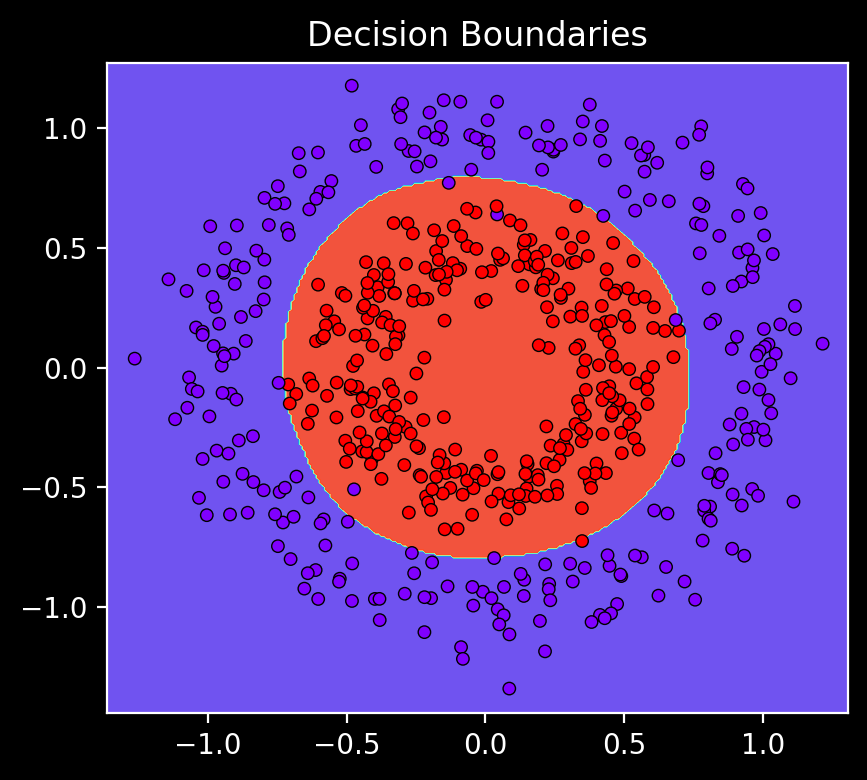

In [27]:
from Plot import plot_model_contours
plot_model_contours(lr, x_train, y_train, trained=True)

Now let's go back and add a hidden layer with 800 neurons or so and see how it performs.

#### Recap
- `torch.nn` encodes neural network operations and their parameters in so called layers

- It also includes a large set of activation and loss functions

- Can design any network by defining the layers then calling them in it's `forward function`

- By including such design in a class inheriting `torch.nn.module` we get free parameter tracking among with other features

Because PyTorch knew you would get sick of defining the calling each layer, they made `nn.sequential`. Can be used if and only if each layer expects a single output and yields a single output.

In [28]:
import torch
import torch.nn as nn

# 1. Define a simple neural network with one hidden layer using nn.Sequential (already wrapped in torch.nn.moduke!)
model = nn.Sequential(
    nn.Linear(784, 128),                    # Input layer (28x28 = 784 pixels)
    nn.ReLU(),                              # Activation function
    nn.Linear(128, 10),                     # Output layer (10 classes for digits 0-9)
    nn.Sigmoid()                            # Output activation function
)

# 2. Generate some random input data
input_data = torch.randn(1, 784)  # Random input tensor of shape (1, 784)

# 3. Forward pass
output = model(input_data)

print("Output probabilities for each class:", output)

Output probabilities for each class: tensor([[0.5081, 0.4942, 0.5082, 0.5084, 0.3866, 0.4329, 0.4445, 0.3968, 0.5403,
         0.4727]], grad_fn=<SigmoidBackward0>)


How about `torch.nn.functional`? It contains functional versions of layers in `torch.nn`; these functional versions don't store state.

In [29]:
import torch
import torch.nn.functional as F

# Analogue of nn.Linear()
x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
w = torch.tensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]])
b = torch.tensor([0.1, 0.2])

linear_output = F.linear(x, w, b)
print("Linear transformation output:", linear_output, sep="\n")

# Analogue of nn.Sigmoid()
sigmoid_output = F.sigmoid(linear_output)
print("\nSigmoid output:", sigmoid_output, sep="\n")

# Analogue of nn.BCELoss()
target = torch.tensor([[0.0, 1.0],
                       [1.0, 0.0]])
bce_loss = F.binary_cross_entropy(sigmoid_output, target)
print("\nBinary Cross Entropy Loss:", bce_loss, sep="\n")

Linear transformation output:
tensor([[1.5000, 3.4000],
        [3.3000, 7.9000]])

Sigmoid output:
tensor([[0.8176, 0.9677],
        [0.9644, 0.9996]])

Binary Cross Entropy Loss:
tensor(2.4177)


<img width="1200" src="https://i.imgur.com/1leI9h9.png">

Now before we move on to implement some applications, let's talk about loss functions and how that relates to the output layer of the neural network.

1. $\text{For Regression Tasks}$
- Use `nn.MSELoss` or `nn.L1loss` or `nn.HuberLoss`, etc.

- Outpuer layer has one neuron (unless it's multioutput regression)

- Activation at the output is nothing or `nn.ReLU` if target must be positive (should makes no difference)


2. $\text{For Binary Classification Tasks}$
- Think first of `nn.BCELoss` or `nn.BCEWithLogitsLoss`

  - The latter takes `ŷ, y` then applies Sigmoid to `ŷ` then applies loss
  
  - Better numerical stability by algebraic simplification/trick
  
- Output layer has 1 neuron

- Activation at the output is `Sigmoid` or nothing if it will be in loss

   - Predict class $1$ if probability exceeds $0.5$
   

3. $\text{For Multiclass Classification Tasks}$
- Think first of `nn.CrossEntropyLoss`

  - It takes `ŷ, y` then applies Softmax to `ŷ` then applies loss
  
  - For $k$ classes ŷ is of dimensionality $k$
  
  - Better numerical stability by algebraic simplification/trick
  
- Output layer has `k` neurons

- Activation at the output is nothing (but implicitly Softmax)

  - Predict class $i$ if ŷ_i$ is the highest
  

4. $\text{For Multi-Label Classification Tasks}$
- Use `nn.BCELoss` or `nn.BCEWithLogitsLoss`

- Output layer has `k` neurons

- Activation at the output is `Sigmoid` or nothing if it will be in loss

  - Can predict multiple classes (e.g., any class with probability exceeding $0.5$)
  

Quick Check:

In [30]:
import torch
import torch.nn as nn

# Let's create some sample data
ŷ = torch.tensor([[0.5, 1.0, 1.5]])

y = torch.tensor([[0.0, 1.0, 0.0]])

# Using nn.BCELoss with sigmoid separately
sigmoid = nn.Sigmoid()
sig_ŷ = sigmoid(ŷ)
bce_loss_sigmoid = nn.BCELoss()(sig_ŷ, y)

# Using nn.BCEWithLogitsLoss
bce_with_logits_loss = nn.BCEWithLogitsLoss()(ŷ, y)

print("BCE Loss with sigmoid:", bce_loss_sigmoid)
print("BCE With Logits Loss:", bce_with_logits_loss)

BCE Loss with sigmoid: tensor(0.9963)
BCE With Logits Loss: tensor(0.9963)


Cross entropy example

In [148]:
import torch
import torch.nn as nn

# Let's create some sample data
logits = torch.tensor([[2.0, 1.0, -1.0],     # output layer logits for first example
                       [-1.1, 2.1, 3.3]])    # output layer logits for second example

target = torch.tensor([0, 2])               # real classes are 0 and 2

# Using nn.CrossEntropyLoss
cross_entropy_loss = nn.CrossEntropyLoss()(logits, target)

print("Cross Entropy Loss with Integer Labels:", cross_entropy_loss)

Cross Entropy Loss with Integer Labels: tensor(0.3108)
